# Moneyball Playoffs Prediction

* Download the dataset from https://www.kaggle.com/wduckett/moneyball-mlb-stats-19622012

**Summary of the code below:**

1. Importing dependencies and acquiring data
2. Performing EDA
3. Filling the missing values of significant features with Regression Imputation
4. Distributing data based on the two leagues mentioned in the categorical feature of 'League'
5. Performing modelling over American League and National League subsets with Logistic Regression and GBDT.

--------------------

In [1]:
#Importing modules and packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.metrics import accuracy_score , log_loss
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

pd.set_option('display.min_rows', 100)
pd.set_option('display.max_columns', 150)

Data Acquisition & Pre-Processing

In [2]:
moneyball = pd.read_csv('moneyball.csv')
#moneyball.shape
moneyball.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


In [3]:
moneyball.isna().sum()

Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      988
RankPlayoffs    988
G                 0
OOBP            812
OSLG            812
dtype: int64

**So here we have NA values in 4 columns. Two of which are significant features (OOBP and OSLG) while the other two are insignificant. Since the number of missing values are far more, I decide to drop the insignificant ones and perform Linear Regression for filling up the values of OOBP and OSLG features.**

------------------------------------------------

# Linear Regression for OOBP and OSLG values

In [4]:
# After dropping all the NA we're left with just 420 rows

moneyball1=moneyball.drop(columns = ['Team','League','Year','RankSeason','RankPlayoffs','Playoffs'])
moneyball1.dropna(axis=0,inplace=True)

(array([ 6., 14., 36., 92., 82., 82., 61., 31., 14.,  2.]),
 array([0.346 , 0.3613, 0.3766, 0.3919, 0.4072, 0.4225, 0.4378, 0.4531,
        0.4684, 0.4837, 0.499 ]),
 <a list of 10 Patch objects>)

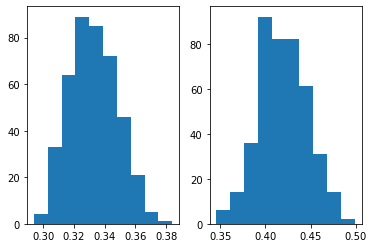

In [5]:
plt.subplot(1,2,1)
plt.hist(moneyball1['OOBP'])
plt.subplot(1,2,2)
plt.hist(moneyball1['OSLG'])

OOBP and OSLG features are significant but have 812 missing values (from 1232 rows)
Hence, carrying out Linear Regression for those two columns in order to predict and add those 812 values (Regression Imputation)

In [6]:
#Splitting the dataset containing the remaining 420 rows into train and test data for OOBP

x_train_OOBP,x_test_OOBP,y_train_OOBP,y_test_OOBP = train_test_split(moneyball1.drop(columns=['OOBP','OSLG']),moneyball1['OOBP']
                                                                     ,test_size = 0.1, random_state=90)

In [7]:
#Modelling the dataset for OOBP

reg1 = LinearRegression()
reg1.fit(x_train_OOBP,y_train_OOBP)

predict_test_OOBP = reg1.predict(x_test_OOBP)

In [8]:
#Splitting the dataset containing the remaining 420 rows into train and test data for OSLG

x_train_OSLG,x_test_OSLG,y_train_OSLG,y_test_OSLG = train_test_split(moneyball1.drop(columns=['OOBP','OSLG']),moneyball1['OSLG']
                                                                     ,test_size = 0.1, random_state=90)

In [9]:
#Modelling the dataset for OSLG

reg2 = LinearRegression()
reg2.fit(x_train_OSLG,y_train_OSLG)

predict_test_OSLG = reg2.predict(x_test_OSLG)

In [10]:
# Error rates of the test OOBP & OSLG values.

print('Error rates for OOBP','\n','Mean Squared error - ',mean_squared_error(y_test_OOBP,predict_test_OOBP),
      '\n','Mean Abs Error - ', mean_absolute_error(y_test_OOBP,predict_test_OOBP))

print('\n','Error rates for OSLG','\n','Mean Squared error - ',mean_squared_error(y_test_OSLG,predict_test_OSLG),
      '\n','Mean Abs Error - ', mean_absolute_error(y_test_OSLG,predict_test_OSLG))


Error rates for OOBP 
 Mean Squared error -  3.336348939130085e-05 
 Mean Abs Error -  0.004375215360776467

 Error rates for OSLG 
 Mean Squared error -  0.00011560582513692498 
 Mean Abs Error -  0.008385228010079187


**The above error rates indicate that the model built for filling up the NA values in OOBP & OSLG columns is performing well.**

In [11]:
moneyball1.head()

,RS,RA,W,OBP,SLG,BA,G,OOBP,OSLG
0,734,688,81,0.328,0.418,0.259,162,0.317,0.415
1,700,600,94,0.320,0.389,0.247,162,0.306,0.378
2,712,705,93,0.311,0.417,0.247,162,0.315,0.403
3,734,806,69,0.315,0.415,0.260,162,0.331,0.428
4,613,759,61,0.302,0.378,0.240,162,0.335,0.424


In [12]:
'''
Upon having a look at the dataset, we see that the OOBP and OSLG have NA values starting from the row #420.

Selecting all the rows for which OOBP and OSLG had their values missing (812 rows) and 
feeding the value of their respective features to the trained Linear Regression models for prediction.

'''

moneyball2 = moneyball.drop(columns = ['Team','League','Year','RankSeason','RankPlayoffs','Playoffs','OOBP','OSLG'])
x_OOBP_OSLG = moneyball2.iloc[420:,:]


################################## Predicting for OOBP ############################################

predict_OOBP = reg1.predict(x_OOBP_OSLG)

################################### Predicting for OSLG ############################################

predict_OSLG = reg2.predict(x_OOBP_OSLG)

In [13]:
'''
Indexing the OOBP and OSLG column from the dataset with dropped NA (420 rows) and appending it with the predicted values 
of OOBP and OSLG respectively.
   
'''

a = moneyball1['OOBP']
new_OOBP = np.append(a,predict_OOBP)

c = moneyball1['OSLG']
new_OSLG = np.append(c,predict_OSLG)

In [14]:
new_OOBP.shape

(1232,)

In [15]:
new_OSLG.shape

(1232,)

In [16]:
###################### Replacing the updated columns and cleaning the dataset #############################

moneyball3 = moneyball.drop(columns=['OOBP','OSLG','RankSeason','RankPlayoffs'])
moneyball3['new_OOBP'] = new_OOBP
moneyball3['new_OSLG'] = new_OSLG

We have a new dataset with all the OOBP and OSLG values

In [17]:
moneyball3.isna().sum()

Team        0
League      0
Year        0
RS          0
RA          0
W           0
OBP         0
SLG         0
BA          0
Playoffs    0
G           0
new_OOBP    0
new_OSLG    0
dtype: int64

In [18]:
moneyball3.League.unique()

array(['NL', 'AL'], dtype=object)

**Since there are 2 major leagues given in the dataset i.e. National League and American League, we will split the dataset and work on them individually.**

--------------------------------------

# Modelling for National League

In [19]:
moneyball_temp1 = moneyball3.loc[moneyball3['League']=='NL'].copy()  
moneyball_temp1.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,G,new_OOBP,new_OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,162,0.306,0.378
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,162,0.335,0.424
6,CIN,NL,2012,669,588,97,0.315,0.411,0.251,1,162,0.305,0.390
8,COL,NL,2012,758,890,64,0.330,0.436,0.274,0,162,0.357,0.470


In [20]:
########    Cleaning the dataset    ########### 

moneyball_temp1.drop(columns=['Team','League','Year'],inplace=True)
moneyball_temp1.head()

,RS,RA,W,OBP,SLG,BA,Playoffs,G,new_OOBP,new_OSLG
0,734,688,81,0.328,0.418,0.259,0,162,0.317,0.415
1,700,600,94,0.320,0.389,0.247,1,162,0.306,0.378
4,613,759,61,0.302,0.378,0.240,0,162,0.335,0.424
6,669,588,97,0.315,0.411,0.251,1,162,0.305,0.390
8,758,890,64,0.330,0.436,0.274,0,162,0.357,0.470


(array([494.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 122.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

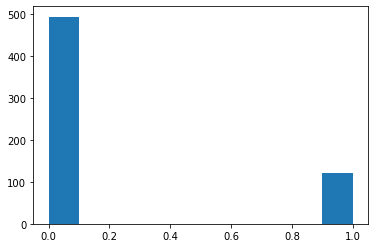

In [21]:
plt.hist(moneyball_temp1['Playoffs'])

In [22]:
# Splitting the dataset into training and testing set 
# stratify makes sure that the distribution of the 1's and 0's is the same in the splits as well

y_true = moneyball_temp1['Playoffs'].values
x_train,x_test,y_train,y_test = train_test_split(moneyball_temp1.drop(columns=['Playoffs']),moneyball_temp1['Playoffs'], 
                                                 stratify=y_true, test_size=0.2, random_state=90)

(array([395.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  97.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

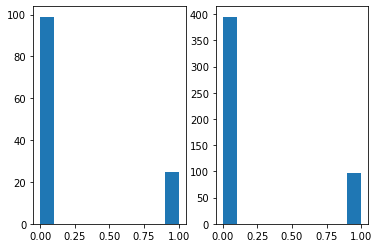

In [23]:
# Confirming the distribution of the classes
plt.subplot(1,2,1)
plt.hist(y_test)
plt.subplot(1,2,2)
plt.hist(y_train)

In [24]:
# Standardizing the data.
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [25]:
# Training the model

log_reg = LogisticRegressionCV(solver="lbfgs", random_state=42, cv = 5, scoring = 'f1')
log_reg.fit(x_train, y_train)

y_probe = log_reg.predict_proba(x_test)
y_predict = log_reg.predict(x_test)
y_predict_train = log_reg.predict(x_train)

In [26]:
print('Logistic Regression:\n','\n','Mean Squared error for train dataset - ',mean_squared_error(y_train,y_predict_train),
      '\n','Mean Abs Error for train dataset - ', mean_absolute_error(y_train,y_predict_train))

print('\n','Mean Squared error for test dataset - ',mean_squared_error(y_test,y_predict),
      '\n','Mean Abs Error for test dataset - ', mean_absolute_error(y_test,y_predict))

Logistic Regression:
 
 Mean Squared error for train dataset -  0.08943089430894309 
 Mean Abs Error for train dataset -  0.08943089430894309

 Mean Squared error for test dataset -  0.056451612903225805 
 Mean Abs Error for test dataset -  0.056451612903225805


In [27]:
accuracy = accuracy_score(y_test, y_predict)
print('Accuracy score:',accuracy)

Accuracy score: 0.9435483870967742


In [28]:
print(confusion_matrix(y_test,y_predict))

[[96  3]
 [ 4 21]]


In [29]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        99
           1       0.88      0.84      0.86        25

    accuracy                           0.94       124
   macro avg       0.92      0.90      0.91       124
weighted avg       0.94      0.94      0.94       124



In [30]:
print("Number of mis-classified points for Logistic Regression :", np.count_nonzero((y_predict - y_test))/y_test.shape[0])

Number of mis-classified points for Logistic Regression : 0.056451612903225805


**XGBClassifier model**

In [31]:
# Limiting the number of base models to upto 300 and max depth of decision trees upto 4, as I dont want to overfit.

params = {
        'n_estimators' : [50, 100, 150, 200, 250, 300], 
        'learning_rate' : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4] ,
        'max_depth': [2, 3, 4],
        'subsample' : [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight' : [1, 3, 5, 7 ],
        'gamma' : [0.0, 0.1, 0.2 , 0.3, 0.4],
        }

In [32]:
# Since the dataset is imbalanced, I use scale_pos_weight with the value set to [(no. of 0's) / (no. of 1's) i.e. (99/25)]

xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1, scale_pos_weight=3.96, random_state = 1)

In [33]:
# referenced from https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

folds = 5
param_comb = 15

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='f1_weighted', 
                                   n_jobs=-1, cv=skf.split(x_train,y_train), random_state= 42)
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000020A16488390>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                  

In [34]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All results:
{'mean_fit_time': array([0.05133772, 0.15119829, 0.30001597, 0.23235483, 0.24750814,
       0.24009981, 0.2444633 , 0.28879833, 0.07123342, 0.06880198,
       0.28842239, 0.04799819, 0.07599945, 0.13039846, 0.07243695]), 'std_fit_time': array([0.01654358, 0.04167799, 0.04095902, 0.06025219, 0.06899834,
       0.07764801, 0.06340704, 0.0889183 , 0.01744058, 0.02182256,
       0.04258088, 0.00357852, 0.00252979, 0.06681836, 0.00413197]), 'mean_score_time': array([0.0047996 , 0.00480223, 0.01280065, 0.00400147, 0.00639973,
       0.00480056, 0.01006832, 0.00560122, 0.00560012, 0.01439896,
       0.01600361, 0.00400071, 0.00480194, 0.00400023, 0.01801925]), 'std_score_time': array([3.92124760e-03, 1.60253066e-03, 1.39487839e-02, 3.57872926e-03,
       3.19986355e-03, 1.60014754e-03, 9.09394660e-03, 4.07926609e-03,
       4.07941561e-03, 1.28007415e-02, 1.61968731e-02, 7.89305942e-07,
       1.59981388e-03, 8.58306885e-07, 2.02887190e-02]), 'param_subsample': masked_array(dat

In [35]:
y_predict_train = random_search.predict_proba(x_train)
y_predict = random_search.predict_proba(x_test)

In [36]:
pred_labels_train = []
pred_labels = []

for i in y_predict_train:
    i = list(i)
    pos = i.index(max(i))
    pred_labels_train.append(pos)

for i in y_predict:
    i = list(i)
    pos = i.index(max(i))
    pred_labels.append(pos)

In [37]:
print('GBDT Classifier:\n','\n','Mean Squared error for train dataset - ',mean_squared_error(y_train,pred_labels_train),
      '\n','Mean Abs Error for train dataset - ', mean_absolute_error(y_train,pred_labels_train))

print('\n','Mean Squared error for test dataset - ',mean_squared_error(y_test,pred_labels),
      '\n','Mean Abs Error for test dataset - ', mean_absolute_error(y_test,pred_labels))

GBDT Classifier:
 
 Mean Squared error for train dataset -  0.054878048780487805 
 Mean Abs Error for train dataset -  0.054878048780487805

 Mean Squared error for test dataset -  0.08064516129032258 
 Mean Abs Error for test dataset -  0.08064516129032258


In [38]:
accuracy = accuracy_score(y_test,pred_labels)
accuracy

0.9193548387096774

In [39]:
print('Confusion matrix of Test data:\n',confusion_matrix(y_test,pred_labels))

Confusion matrix of Test data:
 [[91  8]
 [ 2 23]]


In [40]:
print('Test Data:\n',classification_report(y_test,pred_labels))

Test Data:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95        99
           1       0.74      0.92      0.82        25

    accuracy                           0.92       124
   macro avg       0.86      0.92      0.88       124
weighted avg       0.93      0.92      0.92       124



In [41]:
print("Number of mis-classified points for GBDT :", np.count_nonzero((pred_labels - y_test))/y_test.shape[0])

Number of mis-classified points for GBDT : 0.08064516129032258


-------------------

**As I wanted to improve the results of RandomSearchCV further, I decided to manually tune the parameters, specifically n_estimators (number of base models) and learning_rate (balances out the increased variance caused by increasing n_estimators) to obtain optimum results.**

In [42]:
final_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=4,
              min_child_weight=7, n_estimators=200, n_jobs=-1, random_state=1, scale_pos_weight=3.96, 
              subsample=0.8, verbosity=None)
final_model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.96, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
pred_y = final_model.predict(x_test)
pred_y_train = final_model.predict(x_train)

In [44]:
print('GBDT Classifier:','\n','Mean Squared error for train dataset - ',mean_squared_error(y_train,pred_y_train),
      '\n','Mean Abs Error for train dataset - ', mean_absolute_error(y_train,pred_y_train))

print('\n','Mean Squared error for test dataset - ',mean_squared_error(y_test,pred_y),
      '\n','Mean Abs Error for test dataset - ', mean_absolute_error(y_test,pred_y))

GBDT Classifier: 
 Mean Squared error for train dataset -  0.034552845528455285 
 Mean Abs Error for train dataset -  0.034552845528455285

 Mean Squared error for test dataset -  0.06451612903225806 
 Mean Abs Error for test dataset -  0.06451612903225806


In [45]:
accuracy = accuracy_score(y_test,pred_y)
accuracy

0.9354838709677419

In [46]:
print(confusion_matrix(y_test,pred_y))
#print(confusion_matrix(y_train,pred_labels_train))

[[92  7]
 [ 1 24]]


In [47]:
print(classification_report(y_test,pred_y))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96        99
           1       0.77      0.96      0.86        25

    accuracy                           0.94       124
   macro avg       0.88      0.94      0.91       124
weighted avg       0.95      0.94      0.94       124



In [48]:
print("Number of mis-classified points for GBDT :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])

Number of mis-classified points for GBDT : 0.06451612903225806


---------------------------

**Model with best results for National League: GBDT (n_estimators=200 , learning_rate=0.1 & max_depth=4) with an accuracy score of 93.5% and an f1 score of 0.96 and 0.86 for classes 0 and 1 respectively.**

# Modelling for American League

In [49]:
moneyball_temp2 = moneyball3.loc[moneyball3['League']=='AL'].copy()
moneyball_temp2.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,G,new_OOBP,new_OSLG
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,162,0.331,0.428
5,CHW,AL,2012,748,676,85,0.318,0.422,0.255,0,162,0.319,0.405
7,CLE,AL,2012,667,845,68,0.324,0.381,0.251,0,162,0.336,0.430
9,DET,AL,2012,726,670,88,0.335,0.422,0.268,1,162,0.314,0.402


In [50]:
########      Cleaning the dataset      ########### 

moneyball_temp2.drop(columns=['Team','League','Year'],inplace=True)
moneyball_temp2.head()

,RS,RA,W,OBP,SLG,BA,Playoffs,G,new_OOBP,new_OSLG
2,712,705,93,0.311,0.417,0.247,1,162,0.315,0.403
3,734,806,69,0.315,0.415,0.260,0,162,0.331,0.428
5,748,676,85,0.318,0.422,0.255,0,162,0.319,0.405
7,667,845,68,0.324,0.381,0.251,0,162,0.336,0.430
9,726,670,88,0.335,0.422,0.268,1,162,0.314,0.402


(array([494.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 122.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

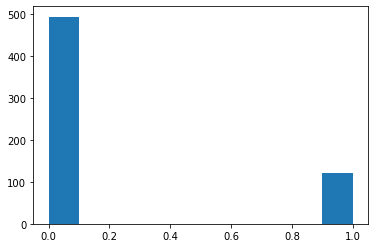

In [51]:
plt.hist(moneyball_temp2['Playoffs'])

* We have a skewed feature to predict as the classes '0' and '1' are not balanced.

In [52]:
# Splitting the dataset into training and testing set 
y_true = moneyball_temp2['Playoffs'].values
x_train,x_test,y_train,y_test = train_test_split(moneyball_temp2.drop(columns=['Playoffs']),moneyball_temp2['Playoffs'],
                                                 stratify = y_true, test_size=0.2, random_state=90)

(array([395.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  97.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

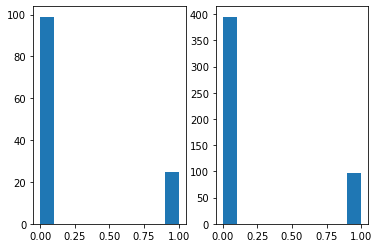

In [53]:
# Confirming the distribution of the classes
plt.subplot(1,2,1)
plt.hist(y_test)
plt.subplot(1,2,2)
plt.hist(y_train)

In [54]:
# Standardizing the data.
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [55]:
# Training the model

log_reg = LogisticRegressionCV(solver='lbfgs', cv=5, scoring='f1', random_state=42)
log_reg.fit(x_train, y_train)

y_probe = log_reg.predict_proba(x_test)
y_predict = log_reg.predict(x_test)
y_predict_train = log_reg.predict(x_train)

In [56]:
# Evaluating the performance of the trained model with different metrics 

print('Logistic Regression:\n','\n','Mean Squared error for train dataset - ',mean_squared_error(y_train,y_predict_train),
      '\n','Mean Abs Error for train dataset - ', mean_absolute_error(y_train,y_predict_train))

print('\n','Mean Squared error for test dataset - ',mean_squared_error(y_test,y_predict),
      '\n','Mean Abs Error for test dataset - ', mean_absolute_error(y_test,y_predict))

Logistic Regression:
 
 Mean Squared error for train dataset -  0.06910569105691057 
 Mean Abs Error for train dataset -  0.06910569105691057

 Mean Squared error for test dataset -  0.08064516129032258 
 Mean Abs Error for test dataset -  0.08064516129032258


In [57]:
accuracy = accuracy_score(y_test,y_predict)
accuracy

0.9193548387096774

In [58]:
print(confusion_matrix(y_test,y_predict))

[[95  4]
 [ 6 19]]


In [59]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        99
           1       0.83      0.76      0.79        25

    accuracy                           0.92       124
   macro avg       0.88      0.86      0.87       124
weighted avg       0.92      0.92      0.92       124



In [60]:
print("Number of mis-classified points for Logistic Regression :", np.count_nonzero((y_predict - y_test))/y_test.shape[0])

Number of mis-classified points for Logistic Regression : 0.08064516129032258


**XGBoost Classifier**

In [61]:
# Limiting the number of base models to upto 300 and max depth of decision trees upto 4, as I dont want to overfit.

params = {
        'n_estimators' : [50, 100, 150, 200, 250, 300],
        'learning_rate' : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4] ,
        'max_depth': [2, 3, 4],
        'subsample' : [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight' : [1, 3, 5, 7 ],
        'gamma' : [0.0, 0.1, 0.2 , 0.3, 0.4]
        }

In [62]:
# Since the dataset is imbalanced, I use scale_pos_weight with the value set to [(no. of 0's) / (no. of 1's) i.e. (99/25)]

xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1, scale_pos_weight=3.96, random_state = 42)

In [63]:
folds = 5
param_comb = 15

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state = 42)

random_search = RandomizedSearchCV(xgb, param_distributions=params, scoring='f1_weighted', 
                                   n_jobs=-1, cv=skf.split(x_train,y_train), random_state= 1, n_iter=param_comb)
random_search.fit(x_train, y_train)


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000020A167FFC00>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                  

In [64]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All results:
{'mean_fit_time': array([0.03839703, 0.07999821, 0.08480029, 0.22399979, 0.21149354,
       0.07364631, 0.08160205, 0.0911984 , 0.08319936, 0.30090661,
       0.12263923, 0.16812353, 0.21005926, 0.13085885, 0.06560616]), 'std_fit_time': array([0.00598534, 0.00876275, 0.00391851, 0.05085243, 0.06337621,
       0.00940384, 0.01376365, 0.02609711, 0.01084949, 0.07646015,
       0.02707483, 0.05014302, 0.08437941, 0.02844161, 0.03185501]), 'mean_score_time': array([0.00320172, 0.0047997 , 0.00159998, 0.00639944, 0.00559788,
       0.00160003, 0.01279945, 0.00160036, 0.00479865, 0.00640011,
       0.00400062, 0.00240107, 0.00400038, 0.01520014, 0.00559998]), 'std_score_time': array([3.92129398e-03, 3.91893862e-03, 3.19995880e-03, 5.98600128e-03,
       4.79704677e-03, 3.20005417e-03, 1.39506165e-02, 3.20072174e-03,
       3.91808225e-03, 3.20005426e-03, 3.57851574e-03, 1.96046212e-03,
       1.29186794e-06, 2.24001409e-02, 5.98675328e-03]), 'param_subsample': masked_array(dat

In [65]:
y_predict_train = random_search.predict_proba(x_train)
y_predict = random_search.predict_proba(x_test)

In [66]:
pred_labels_train = []
pred_labels = []

for i in y_predict_train:
    i = list(i)
    pos = i.index(max(i))
    pred_labels_train.append(pos)

for i in y_predict:
    i = list(i)
    pos = i.index(max(i))
    pred_labels.append(pos)

In [67]:
print('GBDT Classifier:\n','\n','Mean Squared error for train dataset - ',mean_squared_error(y_train,pred_labels_train),
      '\n','Mean Abs Error for train dataset - ', mean_absolute_error(y_train,pred_labels_train))

print('\n','Mean Squared error for test dataset - ',mean_squared_error(y_test,pred_labels),
      '\n','Mean Abs Error for test dataset - ', mean_absolute_error(y_test,pred_labels))

GBDT Classifier:
 
 Mean Squared error for train dataset -  0.0020325203252032522 
 Mean Abs Error for train dataset -  0.0020325203252032522

 Mean Squared error for test dataset -  0.0967741935483871 
 Mean Abs Error for test dataset -  0.0967741935483871


In [68]:
accuracy = accuracy_score(y_test,pred_labels)
print('Accuracy:',accuracy)

Accuracy: 0.9032258064516129


In [69]:
print(confusion_matrix(y_test,pred_labels))

[[92  7]
 [ 5 20]]


In [70]:
print(classification_report(y_test,pred_labels))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        99
           1       0.74      0.80      0.77        25

    accuracy                           0.90       124
   macro avg       0.84      0.86      0.85       124
weighted avg       0.91      0.90      0.90       124



In [71]:
print('Misclassification %age for GBDT :', np.count_nonzero((pred_labels - y_test))/y_test.shape[0])

Misclassification %age for GBDT : 0.0967741935483871


--------------------------

**Model with best results for American League: Logistic Regression with 91.9% accuracy and an f1 score of 0.95 and 0.79 for classes 0 and 1 respectively.**